This Jupyter Notebook plots and analyzes ligand-detected 1H nuclear magnetic resonance spectroscopy (NMR) Diffusion Ordered Spectroscopy (DOSY) data of 5-fluoroindole in the absence and presence of the non-structural protein 5A, domains 2 and 3 (NS5A-D2D3). Data should first be downloaded from Zenodo as detailed in ../README.md. Data are in .ft2 format. Filenames indicate protein and 5-fluoroindole concentrations.

In [1]:
# Import useful stuff
%matplotlib inline
import os, sys
import nmrglue as ng
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from fit_raw import * # the included fit_raw.py file contains some useful functions
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import itertools

d_0uMD2D3_50uM5FI_2


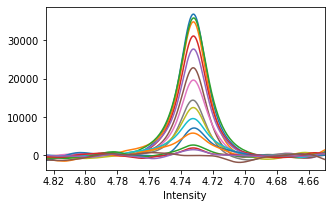

d_0uMD2D3_50uM5FI_0


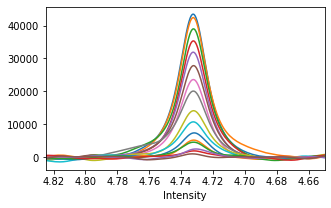

d_0uMD2D3_50uM5FI_1


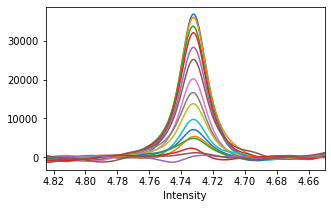

d_75uMD2D3_50uM5FI_0


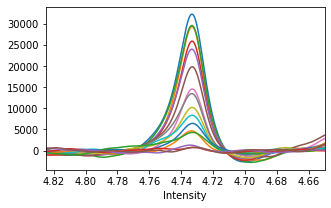

In [2]:
# Plot various 1D slices from each DOSY increment for all experiments

# Create an instance of the fit_raw class
fit_1H_DOSY = fit_raw()

# Read and process data
dic, data = fit_1H_DOSY.read_data('../Data/1H_DOSY_data')

# Check raw data, make sure everything fine
for key in data.keys():
    print(key)
    fig, ax = plt.subplots(figsize=(5,3))
    # Get the x-axis values (ppm_real)
    udic = ng.pipe.guess_udic(dic[key], data[key])
    ppm_real = ng.fileiobase.unit_conversion(udic[1]['size'],True,udic[1]['sw'],udic[1]['obs'],udic[1]['car']).ppm_scale()  
    for i in range(0,data[key].shape[0]):
    # Plot the slices 
        ax.plot(ppm_real, data[key][i])
        ax.set_xlim(4.825, 4.65)
        ax.set_xlabel('1H ppm')
        ax.set_xlabel('Intensity')
    plt.show()


Now fitting d_0uMD2D3_50uM5FI_2


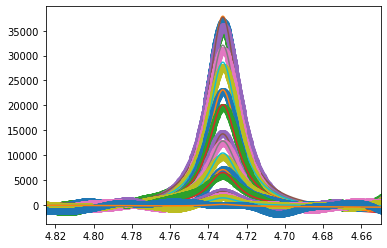

Now fitting d_0uMD2D3_50uM5FI_0


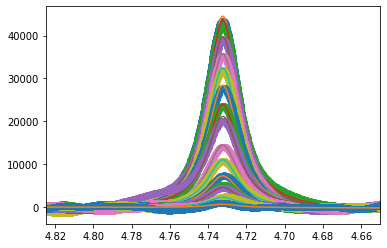

Now fitting d_0uMD2D3_50uM5FI_1


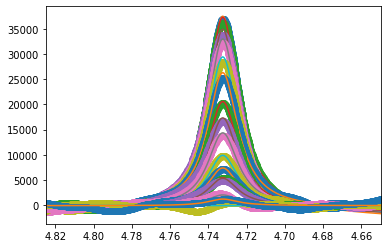

[[Model]]
    Model(dosy)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 48
    # variables        = 1
    chi-square         = 0.03161574
    reduced chi-square = 6.7268e-04
    Akaike info crit   = -349.614455
    Bayesian info crit = -347.743254
[[Variables]]
    Diff:  1.4796e-09 +/- 2.2595e-11 (1.53%) (init = 1e-09)


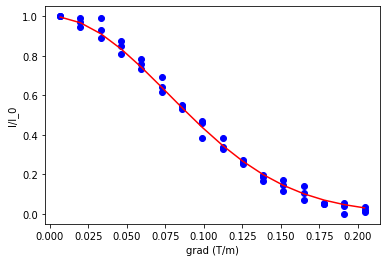

Now fitting d_75uMD2D3_50uM5FI_0


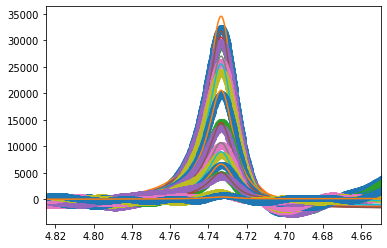

[[Model]]
    Model(dosy)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 11
    # data points      = 16
    # variables        = 1
    chi-square         = 0.02169107
    reduced chi-square = 0.00144607
    Akaike info crit   = -103.655095
    Bayesian info crit = -102.882506
[[Variables]]
    Diff:  1.6508e-09 +/- 6.5622e-11 (3.98%) (init = 1e-09)


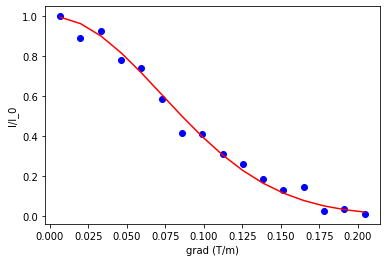

In [3]:
# Fit curves to get peak heights, then fit them

# Define gradients
grads=np.asarray([0.681,1.998,3.315,4.632,5.949,7.265,8.582,9.899,11.216,12.533,13.850,15.166,16.483,17.800,19.117,20.434]) # in Gcm-1

# Make dictionary for groups of data
group_dict = {}
for key in data.keys():
    prefix = key.split('_')[1:3]
    prefix_dec = prefix[1].split('uM')
    join = prefix[0] + "." + "".join(prefix_dec)
    if join.startswith('d'):
        continue
    if join not in group_dict:
        group_dict[join] = []
    group_dict[join].append(key)

# Create a dictionary to store vals by concentration
flat_dosy = {}
concs_dosy_av = {}
concs_dosy_se = {}
fits_dosy = {}
grads_dosy = {}

# Loop over grouped data, calculate average and standard error, and plot
for key in group_dict:
    # Calculate average and standard error
    ints = []

    for i in group_dict[key]:
        print('Now fitting', i)
        # Fit each slice to get intensities
        intensities = fit_1H_DOSY.fit_DOSY_slices(dic=dic[i], data_list=data[i])
        ints.append(intensities/intensities.max()) # Normalise to I_0
        
    reps =  np.asarray(ints).shape[0] # Determine how many repeats there are.
    flat = np.asarray(ints).flatten() # Flatten array with reps
    repeated_arr = list(itertools.islice(itertools.cycle(grads), len(grads) * reps)) # In the case of repeats, add extra gradient values
    
    # Get indices to sort repeated_arr in ascending order. This is to make the plot look nicer.
    order = np.argsort(np.asarray(repeated_arr))
    
    fit, D, D_err = fit_1H_DOSY.fit_DOSY_data(grads=np.asarray(repeated_arr)[order], ydat=flat[order])
    grads_dosy[key] = np.asarray(repeated_arr)[order]
    flat_dosy[key] = flat[order]
    fits_dosy[key] = fit
    concs_dosy_av[key] = D 
    concs_dosy_se[key] = D_err


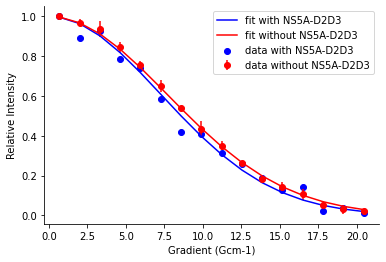

In [4]:
# Make final overlay plot of dosy spectra
# Here, use units of Gcm-1. Relative intensities will not change
fig, ax = plt.subplots()

ax.plot(grads_dosy['75uMD2D3.505FI'], fits_dosy['75uMD2D3.505FI'], color='blue', label='fit with NS5A-D2D3')
ax.plot(grads_dosy['0uMD2D3.505FI'], fits_dosy['0uMD2D3.505FI'], color='red', label='fit without NS5A-D2D3')
ax.scatter(grads_dosy['75uMD2D3.505FI'], np.mean(flat_dosy['75uMD2D3.505FI'].reshape((1,16)),axis=0), color='blue', label='data with NS5A-D2D3')
ax.errorbar(grads_dosy['0uMD2D3.505FI'][0::3], np.mean(flat_dosy['0uMD2D3.505FI'].reshape((-1,3)),axis=1), yerr=np.std(flat_dosy['0uMD2D3.505FI'].reshape((-1,3)),axis=1), fmt='o', color='red', label='data without NS5A-D2D3')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Gradient (Gcm-1)')
ax.set_ylabel('Relative Intensity')
ax.legend()
plt.show()
